In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

In [3]:
classes = os.listdir("leaf_data")
print(classes)

['Acer_Campestre', 'Acer_Capillipes', 'Acer_Circinatum', 'Acer_Mono', 'Acer_Opalus', 'Acer_Palmatum', 'Acer_Pictum', 'Acer_Platanoids', 'Acer_Rubrum', 'Acer_Rufinerve', 'Acer_Saccharinum', 'Alnus_Cordata', 'Alnus_Maximowiczii', 'Alnus_Rubra', 'Alnus_Sieboldiana', 'Alnus_Viridis', 'Arundinaria_Simonii', 'Betula_Austrosinensis', 'Betula_Pendula', 'Callicarpa_Bodinieri', 'Castanea_Sativa', 'Celtis_Koraiensis', 'Cercis_Siliquastrum', 'Cornus_Chinensis', 'Cornus_Controversa', 'Cornus_Macrophylla', 'Cotinus_Coggygria', 'Crataegus_Monogyna', 'Cytisus_Battandieri', 'Eucalyptus_Glaucescens', 'Eucalyptus_Neglecta', 'Eucalyptus_Urnigera', 'Fagus_Sylvatica', 'Ginkgo_Biloba', 'Ilex_Aquifolium', 'Ilex_Cornuta', 'Liquidambar_Styraciflua', 'Liriodendron_Tulipifera', 'Lithocarpus_Cleistocarpus', 'Lithocarpus_Edulis', 'Magnolia_Heptapeta', 'Magnolia_Salicifolia', 'Morus_Nigra', 'Olea_Europaea', 'Phildelphus', 'Populus_Adenopoda', 'Populus_Grandidentata', 'Populus_Nigra', 'Prunus_Avium', 'Prunus_X_Shmitt

In [4]:
image_size = (200, 200)
batch_size = 100

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "leaf_data",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
    class_names=classes
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "leaf_data",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
    class_names=classes
)



Found 1600 files belonging to 100 classes.
Using 1280 files for training.
Found 1600 files belonging to 100 classes.
Using 320 files for validation.


In [17]:
classes_test = os.listdir('google_leaves')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "google_leaves",
    seed=1337,
    image_size=image_size,
    batch_size=6,
    label_mode="categorical",
    class_names=classes_test
)

Found 6 files belonging to 6 classes.


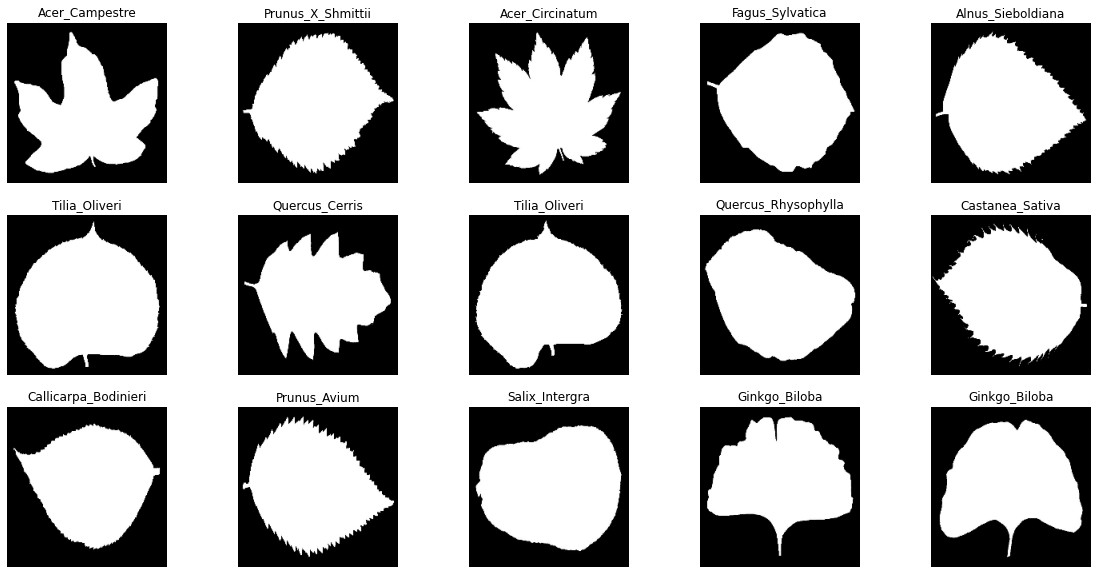

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])])
        plt.axis("off")
plt.show()

In [6]:
from tensorflow.keras.applications.resnet import ResNet101

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization


base_model = ResNet101(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"],)

In [7]:
# train the model on the new data for a few epochs
history = model.fit(train_ds, epochs=40, validation_data=val_ds)

Epoch 1/40
13/13 [==============================] - 158s 12s/step - loss: 4.0291 - accuracy: 0.1430 - val_loss: 4.8092 - val_accuracy: 0.0344
Epoch 2/40
13/13 [==============================] - 157s 12s/step - loss: 2.3717 - accuracy: 0.4547 - val_loss: 4.3133 - val_accuracy: 0.1250
Epoch 3/40
13/13 [==============================] - 163s 13s/step - loss: 1.5595 - accuracy: 0.6695 - val_loss: 4.0248 - val_accuracy: 0.1187
Epoch 4/40
13/13 [==============================] - 167s 13s/step - loss: 1.1530 - accuracy: 0.7695 - val_loss: 3.5741 - val_accuracy: 0.2031
Epoch 5/40
13/13 [==============================] - 168s 13s/step - loss: 0.8590 - accuracy: 0.8555 - val_loss: 3.0800 - val_accuracy: 0.3031
Epoch 6/40
13/13 [==============================] - 170s 13s/step - loss: 0.6477 - accuracy: 0.8953 - val_loss: 2.7470 - val_accuracy: 0.3875
Epoch 7/40
13/13 [==============================] - 171s 13s/step - loss: 0.5220 - accuracy: 0.9156 - val_loss: 2.5472 - val_accuracy: 0.4719
Epoch 

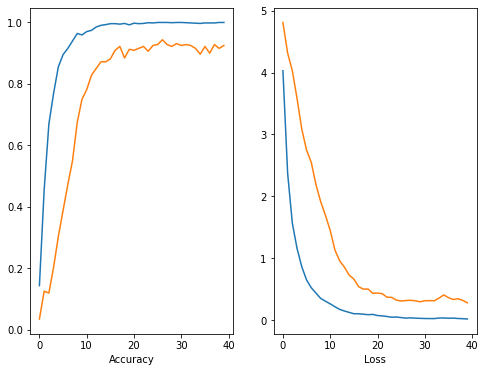

In [8]:
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='training')
plt.plot(history.history['val_accuracy'],label='validation')
plt.xlabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.xlabel('Loss')

plt.show()

In [8]:
predictions = model.predict(val_ds)
labels = tf.concat([y for [_, y] in val_ds], axis=0).numpy()

In [9]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(labels, axis=1), np.argmax(predictions, axis=1))

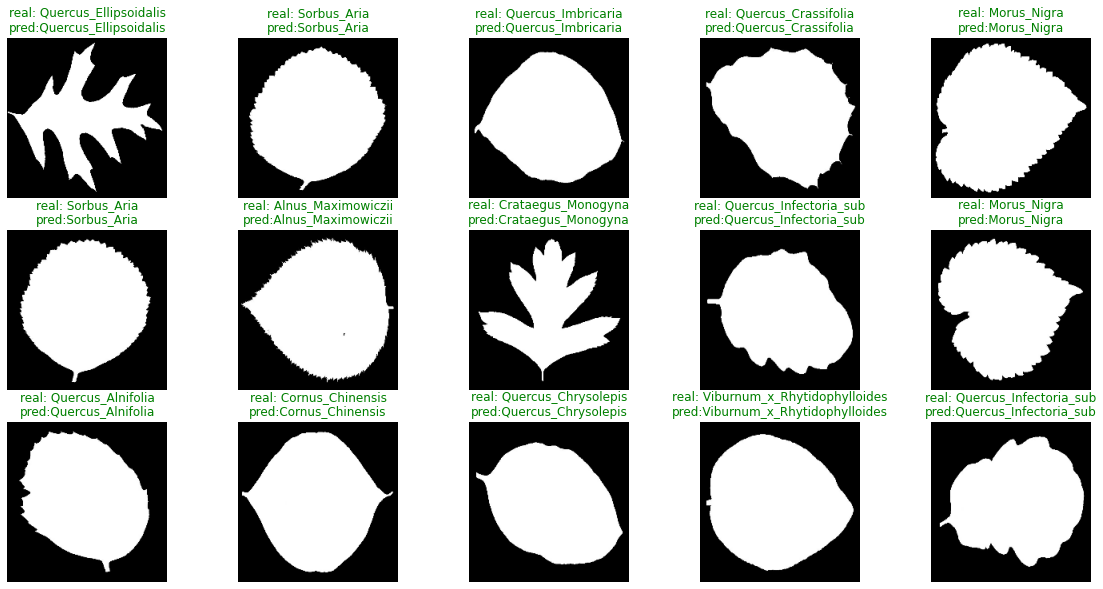

In [10]:
plt.figure(figsize=(20, 10))
for images, labels in val_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        
        img_array = images[i].numpy().astype("uint8")
        prediction = model.predict(np.array([img_array]))
        prediction_name = classes[np.argmax(prediction)]
        real_name = classes[np.argmax(labels[i])]
        
        plt.imshow(img_array)
        if prediction_name == real_name:
            plt.title(f'real: {real_name}\npred:{prediction_name}', fontdict={'color': 'g'})
        else:
            plt.title(f'real: {real_name}\npred:{prediction_name}', fontdict={'color': 'r'})
        
        plt.axis("off")

In [18]:
predictions = model.predict(test_ds)
labels = tf.concat([y for [_, y] in val_ds], axis=0).numpy()

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(labels, axis=1), np.argmax(predictions, axis=1))

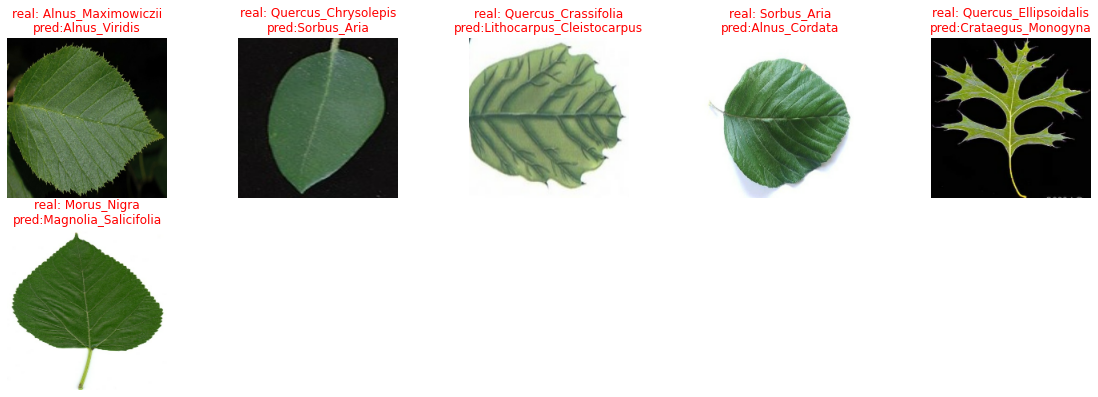

In [23]:
plt.figure(figsize=(20, 10))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 5, i + 1)
        
        img_array = images[i].numpy().astype("uint8")
        prediction = model.predict(np.array([img_array]))
        prediction_name = classes[np.argmax(prediction)]
        real_name = classes_test[np.argmax(labels[i])]
        
        plt.imshow(img_array)
        if prediction_name == real_name:
            plt.title(f'real: {real_name}\npred:{prediction_name}', fontdict={'color': 'g'})
        else:
            plt.title(f'real: {real_name}\npred:{prediction_name}', fontdict={'color': 'r'})
        
        plt.axis("off")

In [16]:
model.save('CNN_leaf_model')

C:\Users\14109\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: CNN_leaf_model\assets


In [ ]:
# opening saved model
#new_model = tf.keras.models.load_model('CNN_leaf_model')

#https://www.tensorflow.org/tutorials/keras/save_and_load